<a href="https://colab.research.google.com/github/lazeicoder/Spam-and-smishing-detection-/blob/master/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter
import random

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
df = pd.read_csv("Dataset_10191.csv")

texts = df["TEXT"].astype(str).tolist()
labels = df["LABEL"].tolist()

# Encode labels: ham, smishing, spam -> 0,1,2
le = LabelEncoder()
y = le.fit_transform(labels)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {np.str_('ham'): np.int64(0), np.str_('smishing'): np.int64(1), np.str_('spam'): np.int64(2)}


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
def simple_tokenize(text):
    return text.lower().split()

counter = Counter()
for text in X_train:
    counter.update(simple_tokenize(text))

MAX_VOCAB = 30000
most_common = counter.most_common(MAX_VOCAB - 2)

# Reserve 0 for PAD, 1 for UNK
word2idx = {"<PAD>": 0, "<UNK>": 1}
for i, (word, _) in enumerate(most_common, start=2):
    word2idx[word] = i

vocab_size = len(word2idx)
print("Vocab size:", vocab_size)

Vocab size: 11057


In [6]:
MAX_LEN = 142

def encode_text(text):
    tokens = simple_tokenize(text)
    ids = [word2idx.get(tok, word2idx["<UNK>"]) for tok in tokens]
    if len(ids) < MAX_LEN:
        ids = ids + [word2idx["<PAD>"]] * (MAX_LEN - len(ids))
    else:
        ids = ids[:MAX_LEN]
    return ids

X_train_enc = np.array([encode_text(t) for t in X_train])
X_test_enc = np.array([encode_text(t) for t in X_test])

In [7]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_enc, y_train)
test_dataset = TextDataset(X_test_enc, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)           # (B, T, E)
        _, (h_n, _) = self.lstm(x)       # h_n: (2, B, H)
        h_forward = h_n[0]
        h_backward = h_n[1]
        h = torch.cat((h_forward, h_backward), dim=1)  # (B, 2H)
        h = self.dropout(h)
        out = self.fc(h)
        return out

num_classes = len(le.classes_)

model = BiLSTMClassifier(
    vocab_size=vocab_size,
    embed_dim=128,
    hidden_dim=128,
    num_classes=num_classes,
    pad_idx=word2idx["<PAD>"]
).to(device)

print(model)

BiLSTMClassifier(
  (embedding): Embedding(11057, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
EPOCHS = 18

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")


Epoch [1/18] - Loss: 0.6086
Epoch [2/18] - Loss: 0.1901
Epoch [3/18] - Loss: 0.0819
Epoch [4/18] - Loss: 0.0586
Epoch [5/18] - Loss: 0.0413
Epoch [6/18] - Loss: 0.0610
Epoch [7/18] - Loss: 0.0405
Epoch [8/18] - Loss: 0.0347
Epoch [9/18] - Loss: 0.0290
Epoch [10/18] - Loss: 0.0343
Epoch [11/18] - Loss: 0.0291
Epoch [12/18] - Loss: 0.0291
Epoch [13/18] - Loss: 0.0251
Epoch [14/18] - Loss: 0.0246
Epoch [15/18] - Loss: 0.0226
Epoch [16/18] - Loss: 0.0244
Epoch [17/18] - Loss: 0.0228
Epoch [18/18] - Loss: 0.0217


In [18]:
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_true.extend(batch_y.numpy())

accuracy = accuracy_score(all_true, all_preds)

print("\nTest Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(
    all_true,
    all_preds,
    target_names=le.classes_,
    digits=4
))

print("Confusion Matrix:")
print(confusion_matrix(all_true, all_preds))


Test Accuracy: 0.982834722903384

Classification Report:
              precision    recall  f1-score   support

         ham     1.0000    0.9985    0.9993       679
    smishing     0.9750    0.9735    0.9742       680
        spam     0.9736    0.9765    0.9750       680

    accuracy                         0.9828      2039
   macro avg     0.9829    0.9828    0.9828      2039
weighted avg     0.9828    0.9828    0.9828      2039

Confusion Matrix:
[[678   1   0]
 [  0 662  18]
 [  0  16 664]]


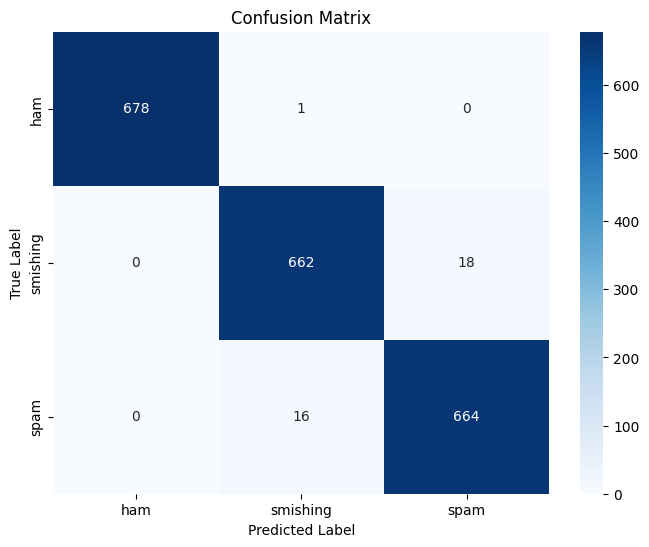

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(all_true, all_preds),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [13]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_true, all_preds)
    return avg_loss, accuracy


In [14]:
EPOCHS = 18

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on training and test sets
    train_acc_epoch = evaluate(model, train_loader, criterion, device)[1]
    test_loss_epoch, test_acc_epoch = evaluate(model, test_loader, criterion, device)

    train_accuracies.append(train_acc_epoch)
    test_losses.append(test_loss_epoch)
    test_accuracies.append(test_acc_epoch)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc_epoch:.4f} - Test Loss: {test_loss_epoch:.4f} - Test Acc: {test_acc_epoch:.4f}")



Epoch [1/18] - Train Loss: 0.0207 - Train Acc: 0.9902 - Test Loss: 0.0595 - Test Acc: 0.9725
Epoch [2/18] - Train Loss: 0.0321 - Train Acc: 0.9848 - Test Loss: 0.0796 - Test Acc: 0.9701
Epoch [3/18] - Train Loss: 0.0411 - Train Acc: 0.9903 - Test Loss: 0.0505 - Test Acc: 0.9760
Epoch [4/18] - Train Loss: 0.0226 - Train Acc: 0.9909 - Test Loss: 0.0413 - Test Acc: 0.9794
Epoch [5/18] - Train Loss: 0.0218 - Train Acc: 0.9910 - Test Loss: 0.0467 - Test Acc: 0.9804
Epoch [6/18] - Train Loss: 0.0197 - Train Acc: 0.9904 - Test Loss: 0.0488 - Test Acc: 0.9784
Epoch [7/18] - Train Loss: 0.0244 - Train Acc: 0.9902 - Test Loss: 0.0505 - Test Acc: 0.9769
Epoch [8/18] - Train Loss: 0.0226 - Train Acc: 0.9910 - Test Loss: 0.0381 - Test Acc: 0.9819
Epoch [9/18] - Train Loss: 0.0240 - Train Acc: 0.9906 - Test Loss: 0.0417 - Test Acc: 0.9819
Epoch [10/18] - Train Loss: 0.0211 - Train Acc: 0.9914 - Test Loss: 0.0374 - Test Acc: 0.9828
Epoch [11/18] - Train Loss: 0.0194 - Train Acc: 0.9909 - Test Loss: 0

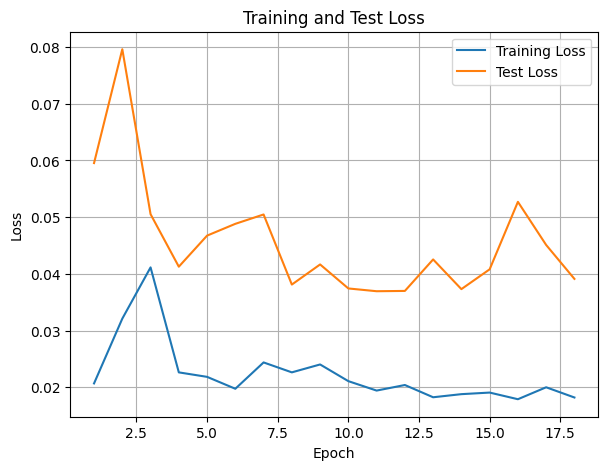

In [20]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(15, 5)) # Increased width here

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

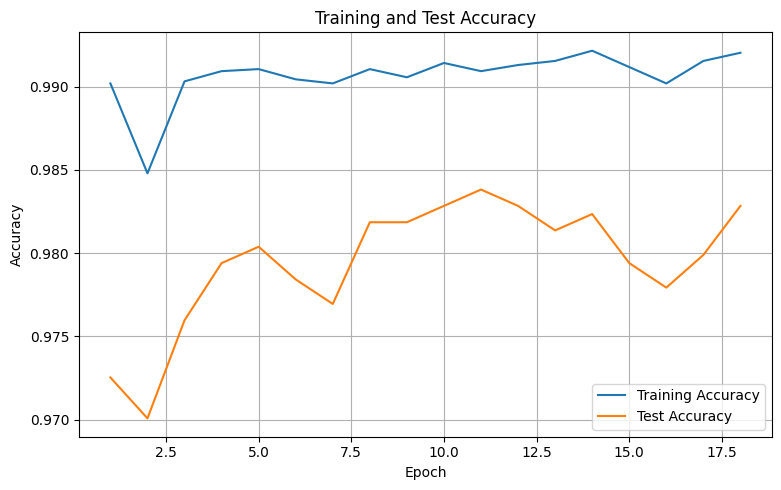

In [23]:
# Plot Accuracy
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()